In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import glob, pdb, os, sys, cv2
from ripser import ripser
from persim import plot_diagrams
import gudhi as gd
from angio import angio_abm
import cv2
import numpy as np
import matplotlib.pyplot as plt


import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
import networkx as nx

import matplotlib.cm as cm


ChatGPT prompts: https://chatgpt.com/share/9345af25-874e-4647-aab8-994e93eb5bd9

In [2]:
def run(chemo, hapto):
    # In[ ]:


    #initialize simulation
    
    #### chemoattractant distribution
    # linear : profile linearly increases with x
    # tumor  : profile max as the point (1,0.5) imitating a tumor center at that location
    C_dist = 'tumor'
    
    #max time units a simulation can run
    final_time = 20.0
    
    #chemotaxis rate
    chemo_rate = 'const'
    
    #how many ABM sims to run simulation
    ABM_sims = 1
    
    hapt_vec = [hapto]#np.round(np.linspace(0,.5,11),2).tolist()
    chi_vec = [chemo]#np.round(np.linspace(0,.5,11),2).tolist()
    
    psi = 0.1
    
    for i in np.arange(ABM_sims):
        
        #print(i)
        # print("")
        for hapt in hapt_vec:
            for chi in chi_vec:
    
                    
                    #initialize ABM simulation
                    A = angio_abm(C_dist,
                                  rho = hapt,
                                  t_final = final_time,
                                  chi = chi,
                                  chemo_rate = chemo_rate,
                                  psi = psi)
    
                    #initialize chemoattractant and TAF grids, sprout locations
                    A.IC_generate()
                    A.sprout_initialize()
    
                    #Record biological data (sprouts, tips, branches)
                    A.record_bio_data()
    
                    #Run the ABM until either one of the sprouts reaches x=0.95
                    #or when time exceeds max_sim_time
                    j = 0
                    max_x = 0
                    while max_x < 0.95:
    
                        #move sprouts
                        A.move_sprouts()
                        #update TAF , chemoattractant
                        A.update_grids()
                        #perform branching
                        A.branch()
    
                        #Save bio info
                        A.record_bio_data()
    
                        #max x value reached by sprout tips
                        max_x = np.max(A.X[A.N==1])
    
                        j+=1
                        if A.dt*j > final_time:
                            #stop simulation if time exceeds max_sim_time
                            break
    
                    A.save_bio_data(i)


    return A

In [3]:
def enhance_for_loops(A):
    # Assuming binary_matrix is your binary image (numpy array)
    # For demonstration, let's create a random binary matrix
    binary_matrix = A.N.T.astype(np.uint8) * 255  # Convert to 8-bit format with 0 and 255
    

    # Define a kernel for dilation (structuring element)
    kernel_size = 2  # You can adjust this size
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    
    # Apply dilation
    dilated_image = cv2.dilate(binary_matrix, kernel, iterations=1)
    
    kernel_size = kernel_size-1  # You can adjust this size
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    eroded_image = cv2.erode(dilated_image, kernel, iterations=1)
    
    # kernel_size = 1 # You can adjust this size
    # kernel = np.ones((kernel_size, kernel_size), np.uint8)
    # final_image = cv2.dilate(eroded_image, kernel, iterations=1)
    final_image = eroded_image.copy()
    return final_image    
    
    
    # # Display the original and dilated images
    # plt.figure(figsize=(10, 10))
    
    # plt.subplot(1, 3, 1)
    # plt.title('Original Binary Image')
    # plt.imshow(binary_matrix, cmap='gray')
    
    # plt.subplot(1, 3, 2)
    # plt.title('Dilated Image')
    # plt.imshow(dilated_image, cmap='gray')
    
    # plt.subplot(1, 3, 3)
    # plt.title('Eroded Image')
    # plt.imshow(eroded_image, cmap='gray')
    
    # plt.show()


In [4]:


def map_to_square(arr,dest):
    # Find the minimum and maximum values for each column (x and y coordinates)
    min_vals = arr.min(axis=0)
    max_vals = arr.max(axis=0)
    
    # Normalize the coordinates to [0, 1]
    norm_arr = (arr - min_vals) / (max_vals - min_vals)
    
    # Scale and shift to [-1, 1]
    shift = dest -np.array([1,0])
    scaled_arr = norm_arr * 2 +shift
    
    return scaled_arr


# Step 1: Skeletonize the Image
def skeletonize_image(binary_image):
    return skeletonize(binary_image // 255).astype(np.uint8)

# Step 2: Detect Nodes and Edges
def detect_nodes_edges(skeleton):
    # Identify all nodes
    # Use a connectivity-8 kernel to find nodes
    kernel = np.array([[1, 1, 1],
                       [1, 10, 1],
                       [1, 1, 1]], dtype=np.uint8)
    convolved = cv2.filter2D(skeleton, -1, kernel)
    
    nodes = np.where((convolved > 10) & (convolved < 18))
    
    return list(zip(nodes[1], nodes[0]))

# Step 3: Create a Graph
def create_graph(skeleton, nodes):
    G = nx.Graph()
    G.add_nodes_from(nodes)
    
    for node in nodes:
        x, y = node
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                if skeleton[y + dy, x + dx] == 1:
                    neighbor = (x + dx, y + dy)
                    if neighbor in nodes:
                        G.add_edge(node, neighbor)
    
    return G

# Step 4: Find Cycles
def find_cycles(graph):
    cycles = list(nx.cycle_basis(graph))
    return cycles




# Optional: Visualize the results
def visualize_cycles(image, cycles):
    plt.imshow(image, cmap='gray')
    for cycle in cycles:
        cycle = np.array(cycle)
        plt.plot(cycle[:, 0], cycle[:, 1], 'r-')
        plt.axis("off")
    
    # plt.savefig("AndersonProc3.png", bbox_inches='tight')


In [5]:
def detectLoops(final_image, plot=True):

    binary_image = cv2.threshold(final_image, 127, 255, cv2.THRESH_BINARY)[1]
    
    skeleton = skeletonize_image(binary_image)
    nodes = detect_nodes_edges(skeleton)
    graph = create_graph(skeleton, nodes)
    cycles_unfiltered = find_cycles(graph)
    
    cycles = [sublist for sublist in cycles_unfiltered if len(sublist) >= 5]
    for cycle in cycles:
        cycle.append(cycle[0])
    
    print(f"Detected {len(cycles)} cycles in the image.")

    if plot == True:
        visualize_cycles(skeleton, cycles)
    
    return skeleton, cycles, graph


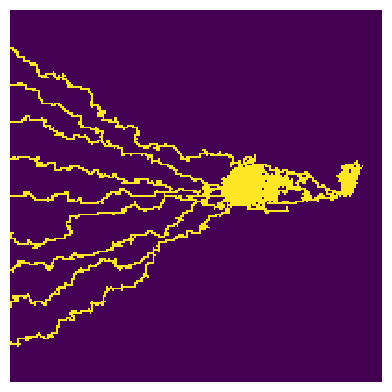

In [6]:
A = run(0.4, 0.05)
plt.matshow(A.N.T)
plt.axis("off")
plt.savefig("Anderson3.png", bbox_inches='tight')

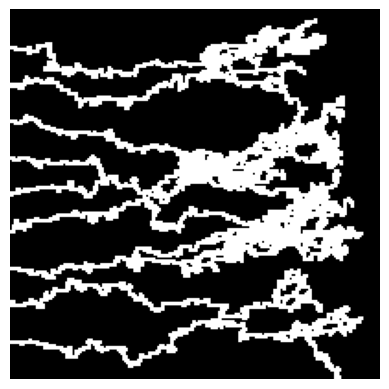

In [27]:
final_image = enhance_for_loops(A)
plt.imshow(final_image, cmap='gray')


Detected 65 cycles in the image.


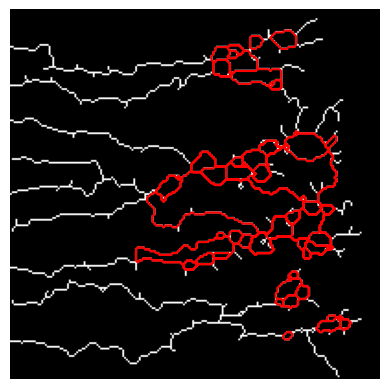

In [39]:
skeleton, cycles, graph = detectLoops(final_image)


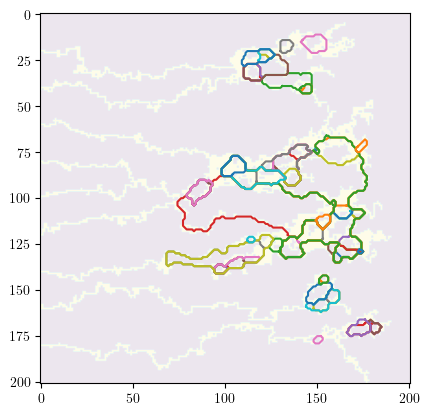

In [31]:
for cycle in cycles:
    arr = np.array(cycle)
    plt.plot(arr[:,0],arr[:,1])

plt.imshow(A.N.T,alpha=0.1)
# plt.axis("off")
# plt.savefig("Anderson3333.png", bbox_inches='tight')

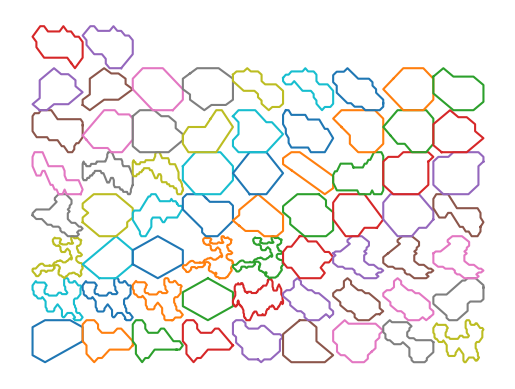

In [44]:
L = int(len(cycles)**(1/2)+1)//2
xList = np.arange(-2*L,2*(L+1),2)
X,Y = np.meshgrid(xList,xList)

i=0
for x,y in zip(X.ravel(),Y.ravel()):
    if (i < len(cycles)):
        arr = map_to_square(np.array(cycles[i]),np.array([x,y]))
        plt.plot(arr[:,0],arr[:,1])
    i+=1


# plt.title("Scaled Extracted Loops")
plt.axis("off")
plt.savefig("loopsAnderson.png",bbox_inches="tight")

In [177]:
loopSizeList = [len(cycle) for cycle in cycles]

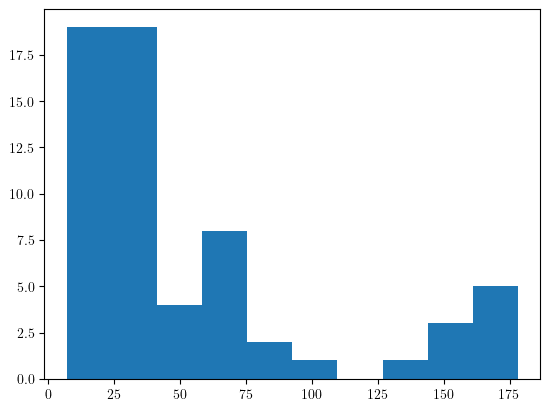

In [178]:
_ = plt.hist(loopSizeList)

Detected 49 cycles in the image.


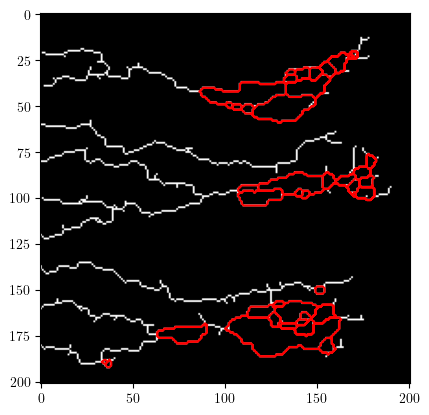

Detected 70 cycles in the image.


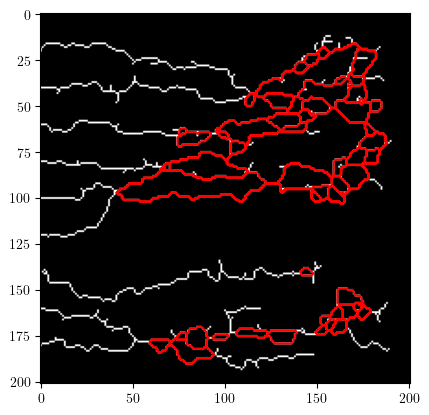

Detected 60 cycles in the image.


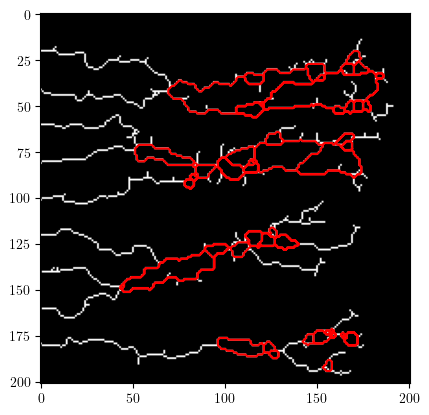

Detected 17 cycles in the image.


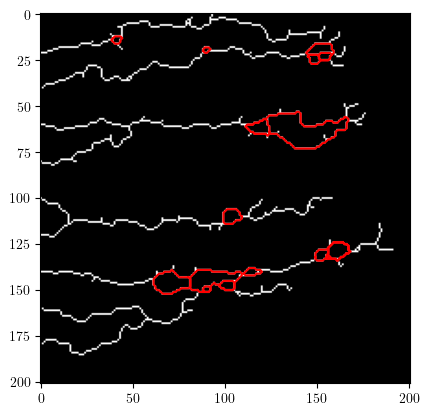

Detected 27 cycles in the image.


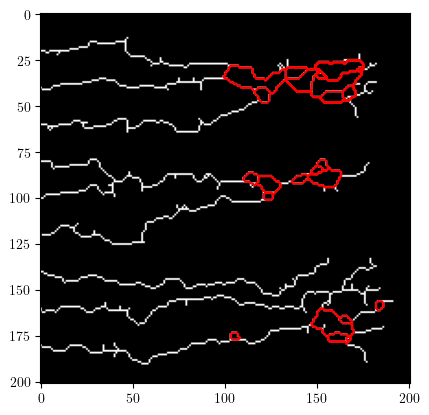

Detected 35 cycles in the image.


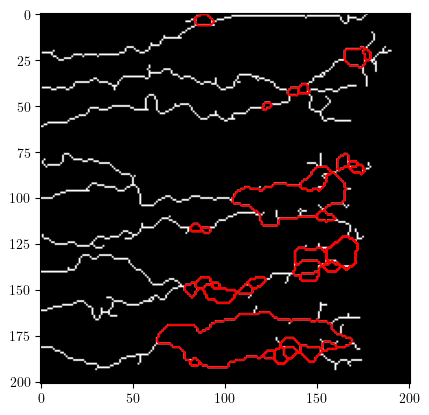

Detected 39 cycles in the image.


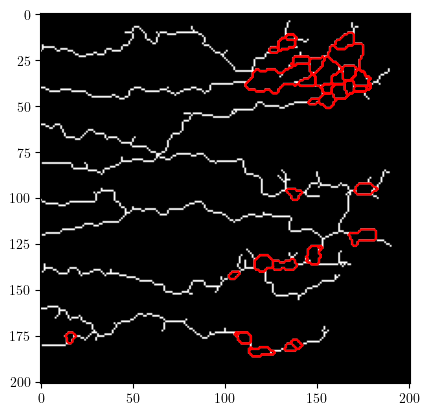

Detected 64 cycles in the image.


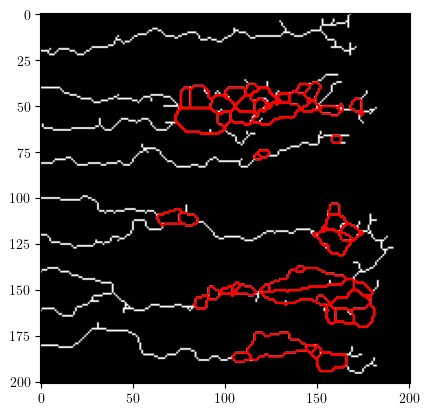

Detected 54 cycles in the image.


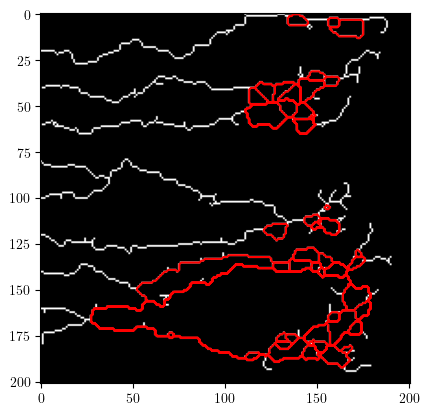

IndexError: index 201 is out of bounds for axis 0 with size 201

In [179]:
result = []
for i in range(30):
    A = run(0.4, 0.4)
    final_image = enhance_for_loops(A)
    skeleton, cycles, graph = detectLoops(final_image)
    loopSizeList = [len(cycle) for cycle in cycles]
    result += loopSizeList.copy()

Text(0, 0.5, 'count')

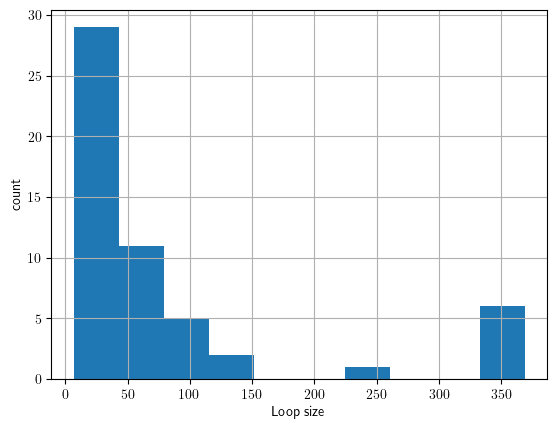

In [192]:
_ = plt.hist(loopSizeList)
plt.grid()
plt.xlabel("Loop size")
plt.ylabel("count")


Detected 1709 segments in the image.


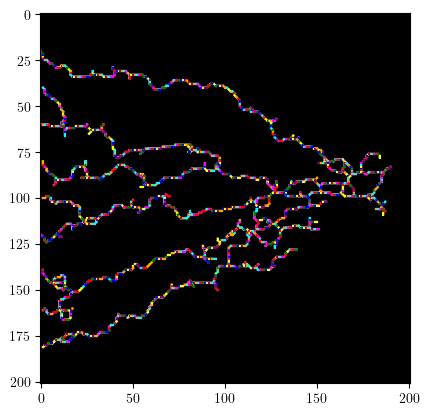

In [120]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
import networkx as nx

# Step 1: Skeletonize the Image
def skeletonize_image(binary_image):
    return skeletonize(binary_image // 255).astype(np.uint8)

# Step 2: Detect Nodes and Edges
def detect_nodes_edges(skeleton):
    # Identify all nodes
    kernel = np.array([[1, 1, 1],
                       [1, 10, 1],
                       [1, 1, 1]], dtype=np.uint8)
    convolved = cv2.filter2D(skeleton, -1, kernel)
    
    nodes = np.where((convolved > 10) & (convolved < 18))
    
    return list(zip(nodes[1], nodes[0]))

# Step 3: Create a Graph
def create_graph(skeleton, nodes):
    G = nx.Graph()
    G.add_nodes_from(nodes)
    
    for node in nodes:
        x, y = node
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                if skeleton[y + dy, x + dx] == 1:
                    neighbor = (x + dx, y + dy)
                    if neighbor in nodes:
                        G.add_edge(node, neighbor)
    
    return G

# Step 4: Find Segments
def find_segments(graph):
    segments = []
    for edge in graph.edges:
        segments.append(edge)
    return segments

# Load and preprocess the image
binary_image = cv2.threshold(final_image, 127, 255, cv2.THRESH_BINARY)[1]

skeleton = skeletonize_image(binary_image)
nodes = detect_nodes_edges(skeleton)
graph = create_graph(skeleton, nodes)
segments = find_segments(graph)

print(f"Detected {len(segments)} segments in the image.")

def visualize_segments(image, segments):
    plt.imshow(image, cmap='gray')
    colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'cyan', 'magenta']
    for i, segment in enumerate(segments):
        x_coords, y_coords = zip(*segment)
        plt.plot(x_coords, y_coords, color=colors[i % len(colors)])
    plt.show()

visualize_segments(skeleton, segments)

In [7]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size,mode="valid")


# def construct_graph_from_sprouts_as_edges(sprouts):
#     """
#     Construct a graph where:
#     - Each sprout is treated as an edge.
#     - The start and end points of each sprout are nodes.
#     - The weight of each edge is the length of the sprout trajectory (number of time points).
    
#     Parameters:
#     - sprouts: List of lists containing the (x, y) coordinates of each sprout's trajectory.
    
#     Returns:
#     - G: A graph where each sprout is an edge and each (start, end) of the sprout is a node.
#     """
    
#     G = nx.Graph()
    
#     for sprout in sprouts:
#         if len(sprout) >= 10:
#             # Get the starting and ending points of the sprout
#             start_node = sprout[0]
#             end_node = sprout[-1]
            
#             # The weight of the edge is the length of the sprout (number of time points)
#             edge_weight = len(sprout)
            
#             # Add an edge between the start and end points with the weight
#             G.add_edge(tuple(start_node), tuple(end_node), weight=edge_weight)
    
#     return G


import networkx as nx

def check_anastomosis(existing_sprouts, new_sprout):
    """
    Check if the new sprout hits any existing sprout in the middle (anastomosis).
    
    Parameters:
    - existing_sprouts: List of existing sprouts (their trajectories).
    - new_sprout: The trajectory of the new sprout being added.
    
    Returns:
    - anastomosis_point: The point where anastomosis occurs (if any), otherwise None.
    - hit_sprout_index: The index of the hit sprout in `existing_sprouts`, or None if no hit.
    """
    for i, sprout in enumerate(existing_sprouts):
        for point in sprout[1:-1]:  # check only the middle points (not start or end)
            if point in new_sprout:
                return point, i  # Return the point of anastomosis and the hit sprout index
    return None, None


def split_sprout_at_anastomosis(sprout, anastomosis_point):
    """
    Split a sprout into two at the anastomosis point.
    
    Parameters:
    - sprout: The full trajectory of the sprout (list of (x, y) coordinates).
    - anastomosis_point: The point where the sprout should be split.
    
    Returns:
    - sprout_before: The part of the sprout before the anastomosis.
    - sprout_after: The part of the sprout after the anastomosis.
    """
    anastomosis_idx = sprout.index(anastomosis_point)
    sprout_before = sprout[:anastomosis_idx + 1]
    sprout_after = sprout[anastomosis_idx:]
    return sprout_before, sprout_after


def construct_graph_with_anastomosis(sprouts):
    """
    Construct a graph that handles anastomosis.
    - Each sprout is treated as an edge.
    - Sprouts are split into multiple edges when anastomosis occurs.
    
    Parameters:
    - sprouts: List of lists containing the (x, y) coordinates of each sprout's trajectory.
    
    Returns:
    - G: A graph where each sprout (or part of a sprout) is an edge, and each (start, end) is a node.
    """
    
    G = nx.Graph()
    existing_sprouts = []

    for sprout in sprouts:
        if len(sprout) >= 2:
            # Check if the new sprout creates an anastomosis with any existing sprout
            anastomosis_point, hit_sprout_index = check_anastomosis(existing_sprouts, sprout)
            
            if anastomosis_point:
                # Split the existing sprout at the anastomosis point
                hit_sprout = existing_sprouts[hit_sprout_index]
                sprout_before, sprout_after = split_sprout_at_anastomosis(hit_sprout, anastomosis_point)
                
                # Update the graph: replace the original sprout with the split parts
                existing_sprouts[hit_sprout_index] = sprout_before
                existing_sprouts.append(sprout_after)
                
                # Add both parts to the graph
                G.add_edge(tuple(sprout_before[0]), tuple(sprout_before[-1]), weight=len(sprout_before))
                G.add_edge(tuple(sprout_after[0]), tuple(sprout_after[-1]), weight=len(sprout_after))
                
                # Split the new sprout at the anastomosis point as well
                new_sprout_before, new_sprout_after = split_sprout_at_anastomosis(sprout, anastomosis_point)
                existing_sprouts.append(new_sprout_before)
                existing_sprouts.append(new_sprout_after)
                
                # Add the split new sprout parts to the graph
                G.add_edge(tuple(new_sprout_before[0]), tuple(new_sprout_before[-1]), weight=len(new_sprout_before))
                G.add_edge(tuple(new_sprout_after[0]), tuple(new_sprout_after[-1]), weight=len(new_sprout_after))
            
            else:
                # No anastomosis, add the whole sprout as an edge
                G.add_edge(tuple(sprout[0]), tuple(sprout[-1]), weight=len(sprout))
                existing_sprouts.append(sprout)

    return G



def remove_short_edges(G, min_length=10):
    """
    Remove edges from the graph G where the edge weight (length) is less than `min_length`.
    
    Parameters:
    - G: The graph from which to remove the edges.
    - min_length: The minimum length (weight) threshold. Edges shorter than this will be removed.
    
    Returns:
    - G: The graph after removing the edges.
    """
    
    # Get the edges to remove (those with weight less than min_length)
    edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < min_length]
    
    # Remove the edges
    G.remove_edges_from(edges_to_remove)
    
    return G


In [8]:
# # Smoothing both x and y columns
# window_size = 4  # You can adjust this value

# sprout = seg = np.array(A.sprouts[3])

# x_smooth = moving_average(sprout[:, 0], window_size)
# y_smooth = moving_average(sprout[:, 1], window_size)

In [9]:
# plt.plot(x_smooth,y_smooth)

In [10]:
# for i in range(50):
#     seg = np.array(A.sprouts[i])
#     x_smooth = moving_average(seg[:, 0], window_size)
#     y_smooth = moving_average(seg[:, 1], window_size)
#     plt.plot(x_smooth,y_smooth)

In [20]:
sproutList = []
for sprout in A.sprouts:
    if len(sprout)> 10:
        sproutList.append(sprout)

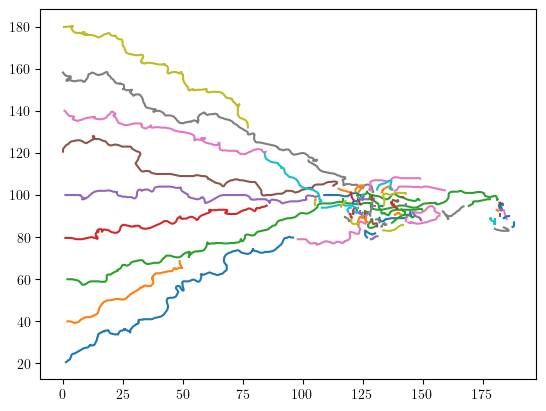

In [21]:
window_size=5
for sprout in sproutList:
    seg = np.array(sprout)
    x = moving_average(seg[:, 0], window_size)
    y = moving_average(seg[:, 1], window_size)
    # plt.plot(seg[:,0],seg[:,1])
    plt.plot(x,y)

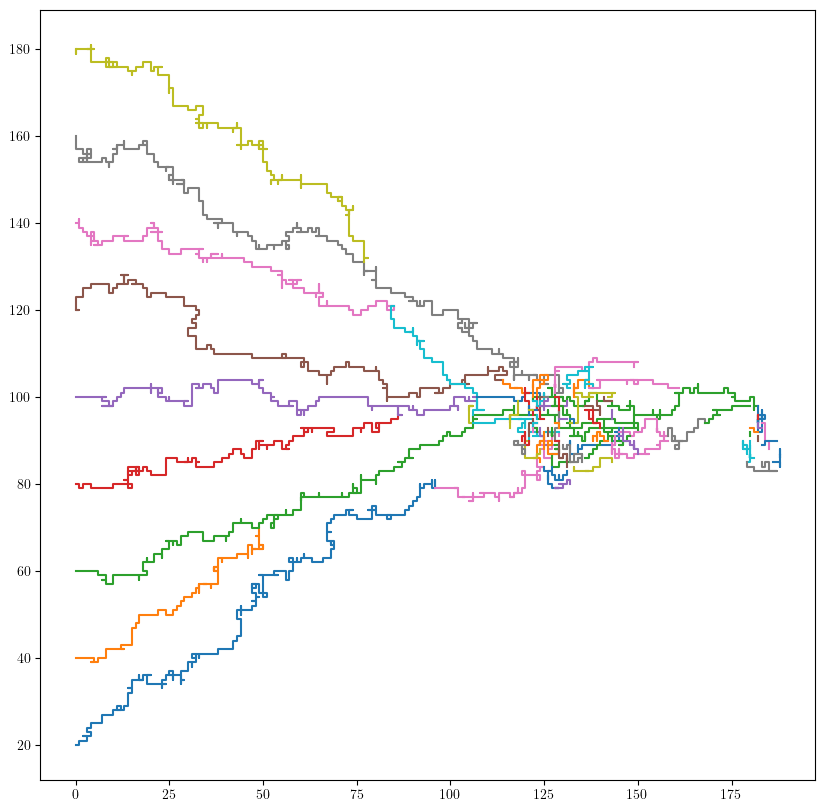

In [22]:
plt.figure(figsize=(10,10))
for sprout in sproutList:
    seg = np.array(sprout)
    # x_smooth = moving_average(seg[:, 0], window_size)
    # y_smooth = moving_average(seg[:, 1], window_size)
    plt.plot(seg[:,0],seg[:,1])